<a href="https://www.kaggle.com/code/lonnieqin/tensorflow-multi-input-pet-pawpularity-model?scriptVersionId=115167230" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# TensorFlow multi-input Pet Pawpularity Model

## Table of Contents
- Summary
- Set up
- Import datasets
- Data Preprocessing
- Model Development
- Model Evaluation
- Submission


## Summary
In this notebook, I will build a TensorFlow multi-input Model that can receive image inputs and tabular inputs at the same time for training, so that I can get the most out of this dataset.
## Set up

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

2022-12-31 13:56:23.229076: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


## Import datasets

In [2]:
train = pd.read_csv("../input/petfinder-pawpularity-score/train.csv")
test = pd.read_csv("../input/petfinder-pawpularity-score/test.csv")
sample_submission = pd.read_csv("../input/petfinder-pawpularity-score/sample_submission.csv")

## Data Preprocessing

In [3]:
train.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [4]:
train["file_path"] = train["Id"].apply(lambda identifier: "../input/petfinder-pawpularity-score/train/" + identifier + ".jpg")
test["file_path"] = test["Id"].apply(lambda identifier: "../input/petfinder-pawpularity-score/test/" + identifier + ".jpg")

In [5]:
train.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,file_path
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,../input/petfinder-pawpularity-score/train/000...
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,../input/petfinder-pawpularity-score/train/000...
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,../input/petfinder-pawpularity-score/train/001...
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,../input/petfinder-pawpularity-score/train/001...
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,../input/petfinder-pawpularity-score/train/001...


<AxesSubplot:>

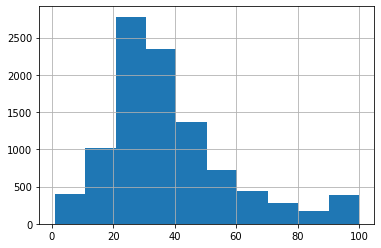

In [6]:
train["Pawpularity"].hist()

## Model Development

In [7]:
tabular_columns = ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur']
image_size = 128
batch_size = 128

### Preprocess funciton

In [8]:
def preprocess(image_url, tabular):
    image_string = tf.io.read_file(image_url)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.central_crop(image, 1.0)
    image = tf.image.resize(image, (image_size, image_size))
    return (image, tabular[1:]), tf.cast(tabular[0], tf.float32)

### Tabular Model

In [9]:
def build_tabular_model(inputs):
    width = 64
    depth = 3
    activation = "relu"
    dropout = 0.1
    x = keras.layers.Dense(
            width, 
            activation=activation
        )(inputs)
    for i in range(depth):
        if i == 0:
            x = inputs
        x = keras.layers.Dense(
            width, 
            activation=activation
        )(x)
        x = keras.layers.Dropout(dropout)(x)
        if (i + 1) % 3 == 0:
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Concatenate()([x, inputs])
    return x

### RMSE

In [10]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean((y_true -  y_pred) ** 2))

In [11]:
def block(x, filters, kernel_size, repetitions, pool_size=2, strides=2):
    for i in range(repetitions):
        x = tf.keras.layers.Conv2D(filters, kernel_size, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size, strides)(x)
    return x

In [12]:
def get_model():
    image_inputs = tf.keras.Input((image_size, image_size , 3))
    tabular_inputs = tf.keras.Input(len(tabular_columns))
    image_x = block(image_inputs, 8, 3, 2)
    image_x = block(image_x, 16, 3, 2)
    image_x = block(image_x, 32, 3, 2)
    image_x = block(image_x, 64, 3, 2)
    image_x = block(image_x, 128, 3, 2)
    image_x = tf.keras.layers.GlobalAveragePooling2D()(image_x)
    
    tabular_x = build_tabular_model(tabular_inputs)
    
    x = tf.keras.layers.Concatenate(axis=1)([image_x, tabular_x])
    output = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs=[image_inputs, tabular_inputs], outputs=[output])
    return model

Let's have a big picture of how this Model looks like.

2022-12-31 13:56:29.464729: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-31 13:56:29.468511: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-12-31 13:56:29.539092: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-31 13:56:29.540135: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-12-31 13:56:29.540225: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-12-31 13:56:29.570077: I tensorflow/stream_executor/platform/def

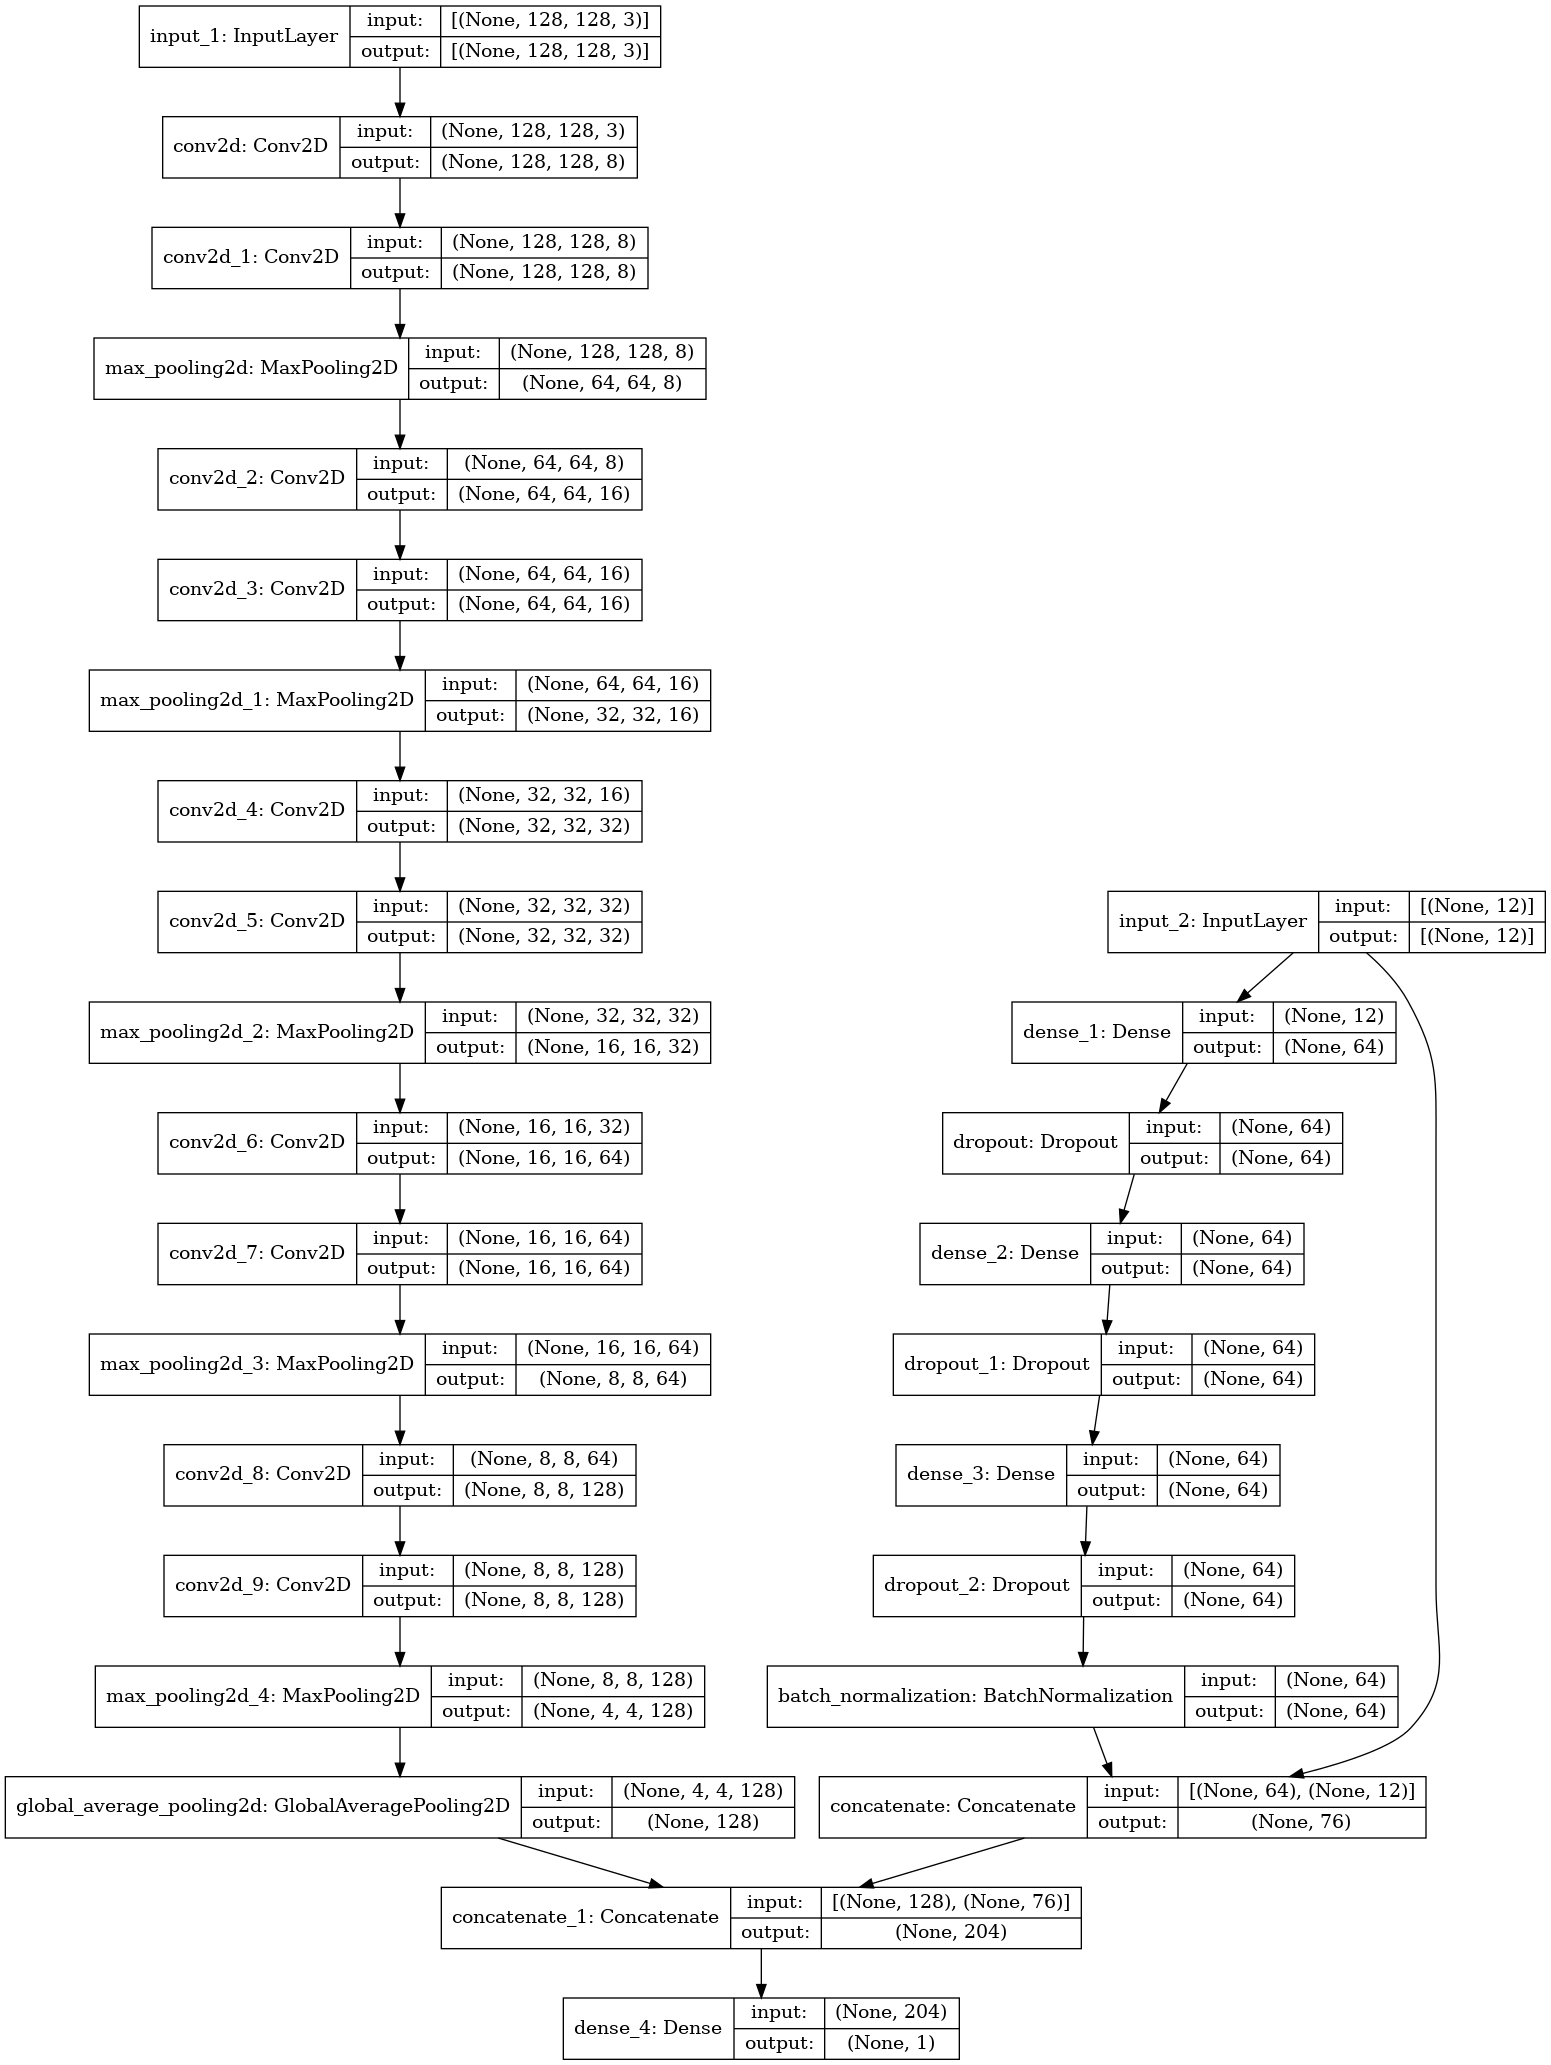

In [13]:
model = get_model()
tf.keras.utils.plot_model(model, show_shapes=True)

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 8)  224         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  584         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 8)    0           conv2d_1[0][0]                   
______________________________________________________________________________________________

This Model accepts images with shape (image_size, image_size, 3) and tabular information with shape (12) as input. Since it's a Regression problem, it generate output with shape (1). 

In [15]:
image = np.random.normal(size=(1, image_size, image_size, 3))
tabular = np.random.normal(size=(1, len(tabular_columns)))
print(image.shape, tabular.shape)
print(model((image, tabular)).shape)

(1, 128, 128, 3) (1, 12)


2022-12-31 13:56:33.551028: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2022-12-31 13:56:39.282846: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11


(1, 1)


2022-12-31 13:56:40.147780: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


### Model Training
I will use tensorflow Dataset here to preprocess and cache tensors, first epoch is very slow because it's preprocessing data; after that, it would be must faster.

Epoch 1/300


2022-12-31 13:56:41.570827: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-31 13:56:41.582503: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000150000 Hz


62/62 [==============================] - 147s 2s/step - loss: 954.6080 - mae: 23.9922 - rmse: 29.6297 - mape: 85.5705 - val_loss: 491.2318 - val_mae: 15.5070 - val_rmse: 22.0928 - val_mape: 65.1291
Epoch 2/300
62/62 [==============================] - 2s 34ms/step - loss: 448.9270 - mae: 15.8855 - rmse: 21.1097 - mape: 83.7150 - val_loss: 450.9304 - val_mae: 15.8769 - val_rmse: 21.1695 - val_mape: 78.0925
Epoch 3/300
62/62 [==============================] - 2s 35ms/step - loss: 433.9584 - mae: 15.6553 - rmse: 20.7505 - mape: 83.7840 - val_loss: 446.3166 - val_mae: 15.7131 - val_rmse: 21.0580 - val_mape: 77.2073
Epoch 4/300
62/62 [==============================] - 2s 35ms/step - loss: 432.7715 - mae: 15.6494 - rmse: 20.7232 - mape: 84.3164 - val_loss: 445.2507 - val_mae: 15.9532 - val_rmse: 21.0373 - val_mape: 80.1082
Epoch 5/300
62/62 [==============================] - 2s 35ms/step - loss: 430.5622 - mae: 15.6046 - rmse: 20.6693 - mape: 84.1282 - val_loss: 443.7083 - val_mae: 15.9084 - 

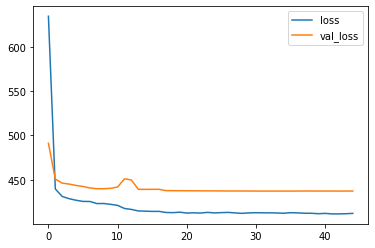

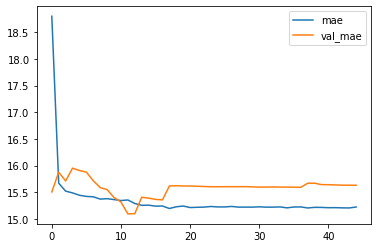

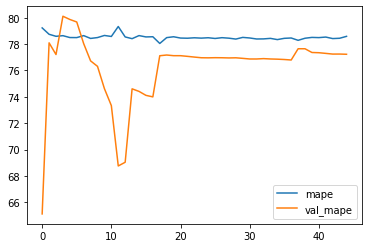

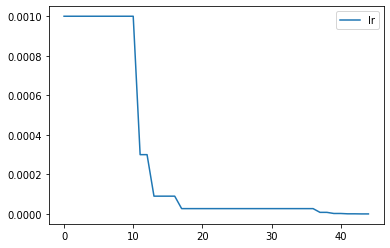

In [16]:
tf.keras.backend.clear_session()
models = []
historys = []
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
# For the current random state, 5th fold can generate a better validation rmse and faster convergence.
train_best_fold = True
best_fold = 0
for index, (train_indices, val_indices) in enumerate(kfold.split(train)):
    if train_best_fold and index != best_fold:
        continue
    x_train = train.loc[train_indices, "file_path"]
    tabular_train = train.loc[train_indices, ["Pawpularity"] + tabular_columns]
    x_val= train.loc[val_indices, "file_path"]
    tabular_val = train.loc[val_indices, ["Pawpularity"] + tabular_columns]
    checkpoint_path = "model_%d.h5"%(index)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path, 
        save_best_only=True
    )
    early_stop = tf.keras.callbacks.EarlyStopping(
        min_delta=1e-4, 
        patience=10
    )
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        factor=0.3,
        patience=2, 
        min_lr=1e-7
    )
    callbacks = [early_stop, checkpoint, reduce_lr]
    
    optimizer = tf.keras.optimizers.Adam(1e-3)
    
    train_ds = tf.data.Dataset.from_tensor_slices((x_train, tabular_train)).map(preprocess).shuffle(512).batch(batch_size).cache().prefetch(2)
    val_ds = tf.data.Dataset.from_tensor_slices((x_val, tabular_val)).map(preprocess).batch(batch_size).cache().prefetch(2)
    model = get_model()
    model.compile(loss="mse", optimizer=optimizer, metrics=["mae", rmse, "mape"])
    history = model.fit(train_ds, epochs=300, validation_data=val_ds, callbacks=callbacks)
    for metrics in [("loss", "val_loss"), ("mae", "val_mae"), ("mape", "val_mape"), ["lr"]]:
        pd.DataFrame(history.history, columns=metrics).plot()
        plt.show()
    model.load_weights(checkpoint_path)
    historys.append(history)
    models.append(model)

## Submission

In [17]:
def preprocess_test_data(image_url, tabular):
    print(image_url, tabular)
    image_string = tf.io.read_file(image_url)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.central_crop(image, 1.0)
    image = tf.image.resize(image, (image_size, image_size))
    # 0 won't be used in prediction, but it's needed in this senario or the tabular variable is treated as label.
    return (image, tabular), 0

In [18]:
test_ds = tf.data.Dataset.from_tensor_slices((test["file_path"], test[tabular_columns])).map(preprocess_test_data).batch(batch_size).cache().prefetch(2)

Tensor("args_0:0", shape=(), dtype=string) Tensor("args_1:0", shape=(12,), dtype=int64)


In [19]:
use_best_result = False
if use_best_result:
    if train_best_fold:
        best_model = models[0]
    else:
        best_fold = 0
        best_score = 10e8
        for fold, history in enumerate(historys):
            for val_rmse in history.history["val_rmse"]:
                if val_rmse < best_score:
                    best_score = val_rmse
                    best_fold = fold
        print("Best Score:%.2f Best Fold: %d"%(best_score, best_fold + 1))
        best_model = models[best_fold]
    results = best_model.predict(test_ds).reshape(-1)
else:
    total_results = []
    for model in models:
        total_results.append(model.predict(test_ds).reshape(-1))
    results = np.mean(total_results, axis=0).reshape(-1)
sample_submission["Pawpularity"] = results
sample_submission.to_csv("submission.csv", index=False)